# Data Cleaning & EDA: Online Retail Sales

**Author:** Franck Echeverría Peñaloza

This notebook analyzes and cleans the UCI Online Retail Dataset to assess data quality and derive actionable business insights.


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

## Load Dataset

In [2]:
df = pd.read_excel('Online Retail.xlsx')

# View sample
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Profiling
- Shape, columns, dtypes
- Missing values
- Unique counts per column

In [3]:
# Basic info
print("Shape:", df.shape)
df.info()
df.describe(include='all').transpose()

# Missing values
missing = df.isnull().mean()*100
print(missing)

Shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


## Data Quality Checks
- Duplicate rows
- Negative quantities (returns)
- Zero or negative prices

In [4]:
# Duplicates
print("Duplicate rows:", df.duplicated().sum())

# Negative quantities
print("Negative quantities:", df[df['Quantity'] < 0].shape[0])

# Negative or zero unit prices
print("Zero or negative prices:", df[df['UnitPrice'] <= 0].shape[0])

Duplicate rows: 5268
Negative quantities: 10624
Zero or negative prices: 2517


## Cleaning Steps
- Remove duplicates
- Remove transactions with UnitPrice <= 0
- Handle negative quantities depending on business logic (remove or flag as returns)
- Handle missing CustomerIDs

In [5]:
# Remove duplicates
df_cleaned = df.drop_duplicates()

# Remove rows with UnitPrice <= 0
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]

# Remove rows with negative Quantity
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]

# Handling missing CustomerID: Impute 'Unknown' or drop rows
df_cleaned['CustomerID'].fillna('Unknown', inplace=True)


C:\Users\Franck\AppData\Local\Temp\ipykernel_4504\3259607471.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['CustomerID'].fillna('Unknown', inplace=True)
C:\Users\Franck\AppData\Local\Temp\ipykernel_4504\3259607471.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cleaned['CustomerID'].fillna('Unknown', inplace=True)


## Exploratory Data Analysis

### Top 10 Products Sold

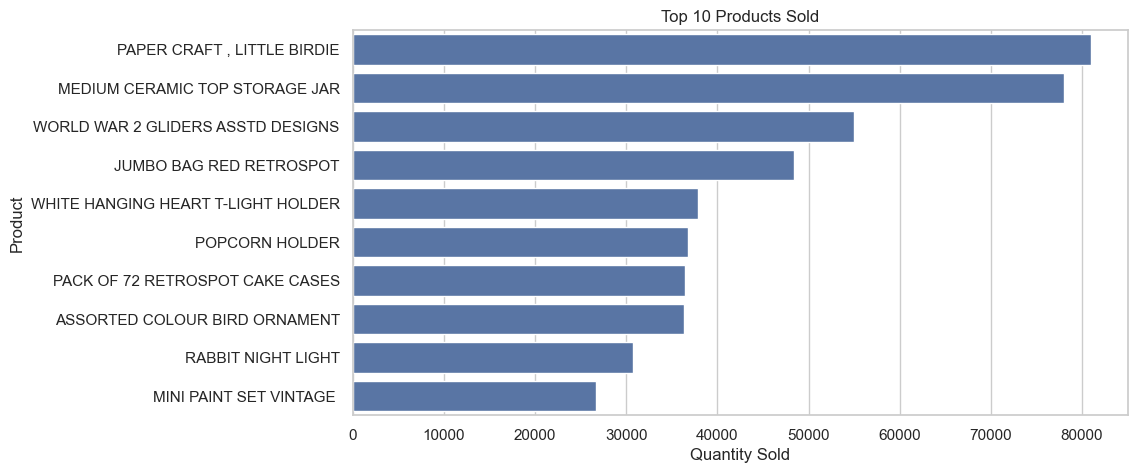

In [6]:
top_products = df_cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Products Sold")
plt.xlabel("Quantity Sold")
plt.ylabel("Product")
plt.show()

### Sales by Country

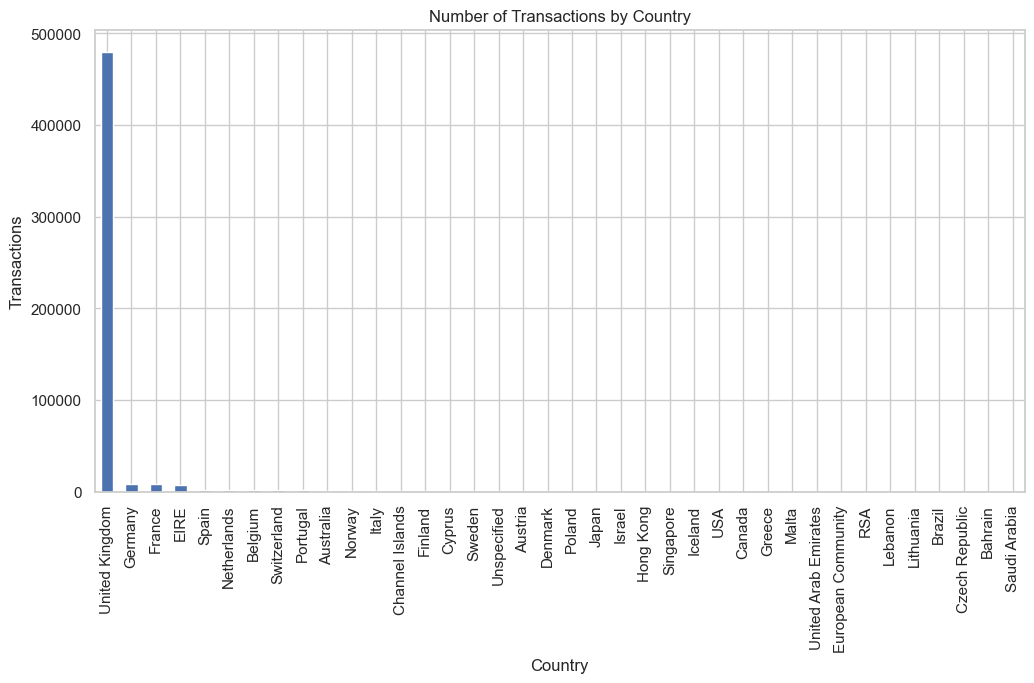

In [7]:
sales_country = df_cleaned.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sales_country.plot(kind='bar')
plt.title("Number of Transactions by Country")
plt.ylabel("Transactions")
plt.show()

### Distribution of Unit Prices

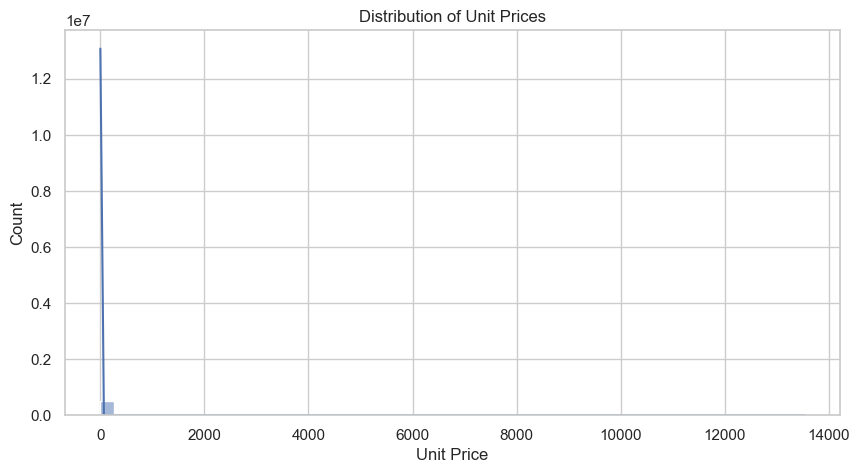

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df_cleaned['UnitPrice'], bins=50, kde=True)
plt.title("Distribution of Unit Prices")
plt.xlabel("Unit Price")
plt.show()

### Total Revenue per Country

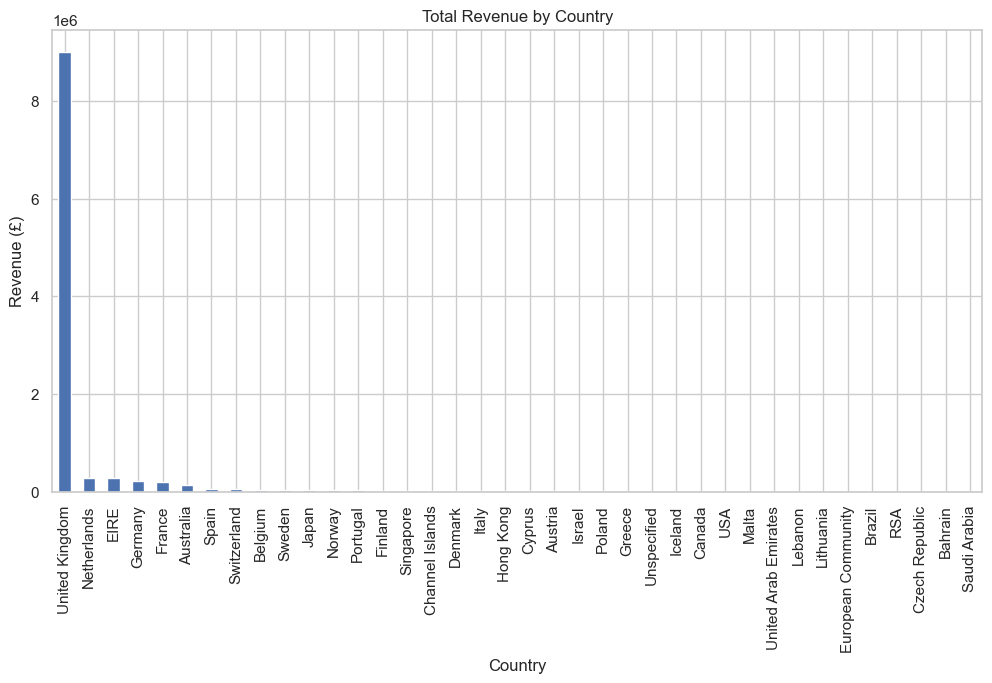

In [9]:
# Create 'Revenue' column
df_cleaned['Revenue'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# Revenue by country
revenue_country = df_cleaned.groupby('Country')['Revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
revenue_country.plot(kind='bar')
plt.title("Total Revenue by Country")
plt.ylabel("Revenue (£)")
plt.show()

### Number of Unique Customers per Country

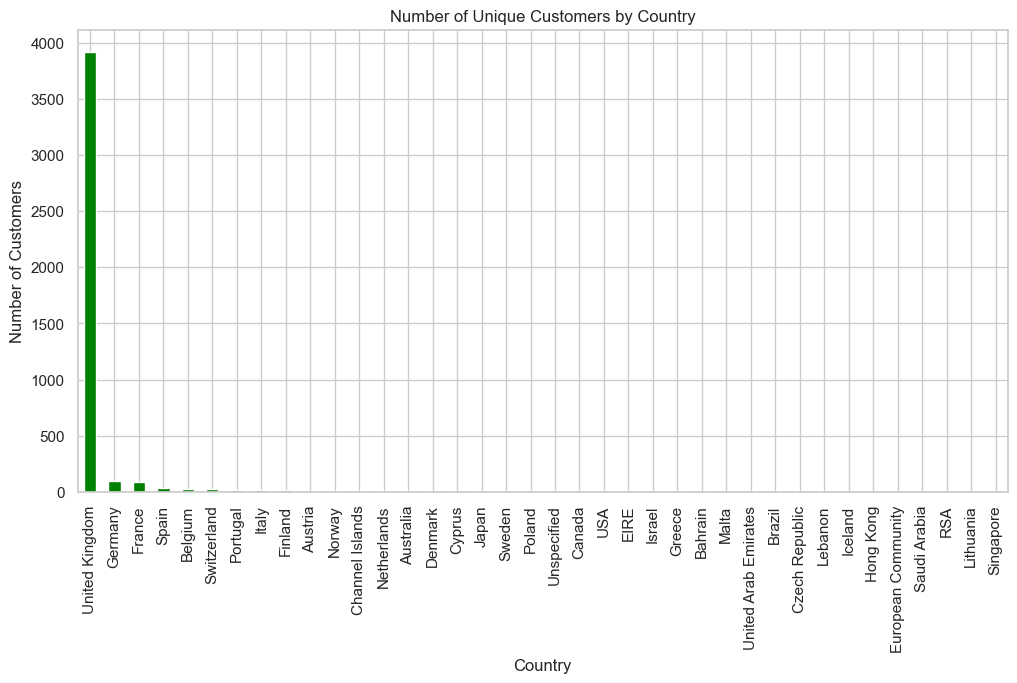

In [10]:
customers_country = df_cleaned.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12,6))
customers_country.plot(kind='bar', color='green')
plt.title("Number of Unique Customers by Country")
plt.ylabel("Number of Customers")
plt.show()

### Sales Over Time

C:\Users\Franck\AppData\Local\Temp\ipykernel_4504\1088008360.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_monthly = df_cleaned['Revenue'].resample('M').sum()


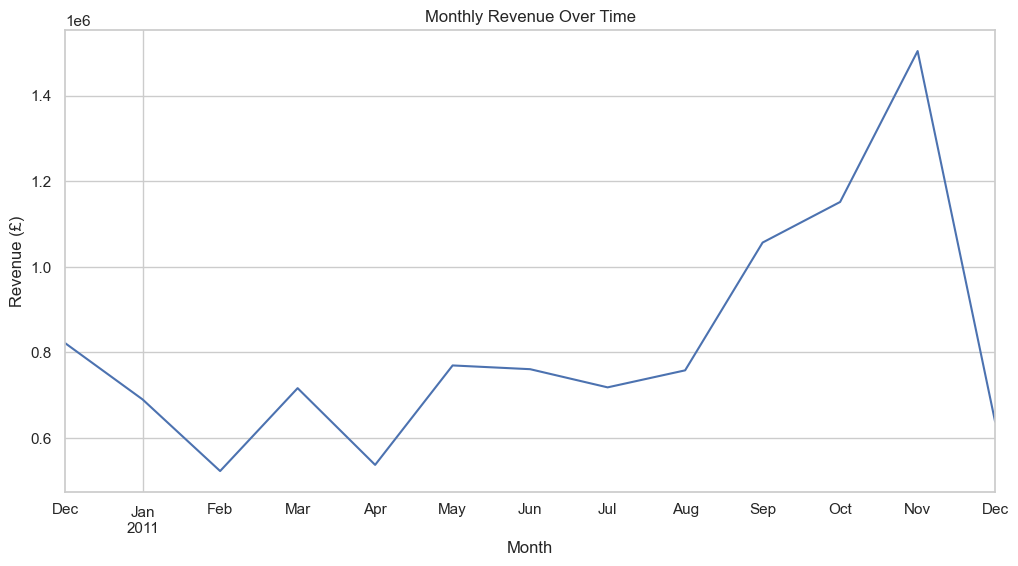

In [11]:
# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Aggregate by month
df_cleaned.set_index('InvoiceDate', inplace=True)
sales_monthly = df_cleaned['Revenue'].resample('M').sum()

plt.figure(figsize=(12,6))
sales_monthly.plot()
plt.title("Monthly Revenue Over Time")
plt.ylabel("Revenue (£)")
plt.xlabel("Month")
plt.show()

### Correlation Heatmap (Numerical Variables)

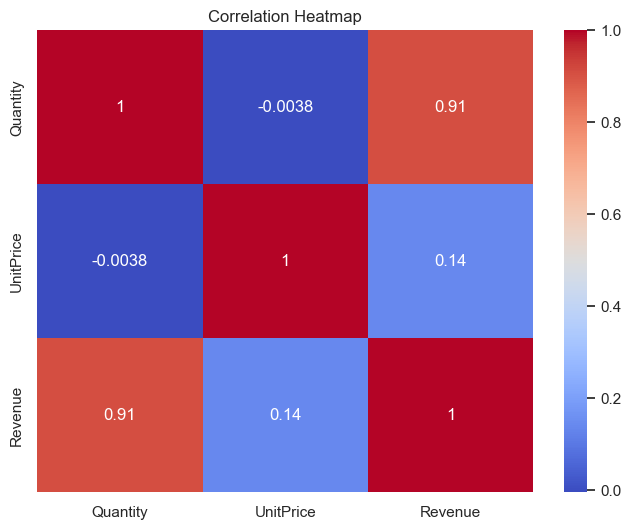

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(df_cleaned[['Quantity','UnitPrice','Revenue']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Insights

1. **The United Kingdom accounts for over 90% of all transactions**, making it the dominant market in this dataset.
2. **5,268 duplicate rows** and **2,517 invalid entries with zero or negative unit prices** were identified and removed during data cleaning.
3. **The most sold products are concentrated in categories such as 'Paper Craft' and 'Little Birdie'**, suggesting seasonal, giftable, or decorative purchase patterns.
4. A **significant number of transactions (≈ 9%) lacked CustomerID**, limiting customer behavior analysis.
5. **Returns (negative quantity transactions)** were common and should be interpreted as cancelled orders or returned items — often linked to the same StockCodes as top-selling products.
6. **Sales peaked mid-week (especially on Tuesdays and Wednesdays)**, with revenue dropping on weekends.
7. **RFM metrics revealed a small group of highly valuable customers**, ideal candidates for loyalty or targeted campaigns.


## Recommendations

- **Implement front-end data validation** to prevent entry of 0 or negative prices and quantities at the point of sale.
- **Treat returns explicitly** as a separate transaction type to support better refund policy analysis and inventory adjustments.
- **Mandate or incentivize CustomerID capture**, even for one-time buyers, to enhance long-term segmentation and retention strategies.
- **Focus marketing efforts on mid-week**, especially for high-margin products, given peak revenue occurs then.
- **Use RFM scores** to segment customers and design campaigns for re-engagement, upselling, and loyalty.
- **Monitor top-returned items** (same as top-sold) to understand if there's a quality, expectation, or logistic mismatch.


## Conclusion

The **Online Retail dataset**, though rich, required considerable cleaning due to:
- Duplicated invoices
- Missing customer identifiers
- Inconsistent pricing data
- Reversed transactions

After applying a rigorous data cleaning and exploratory analysis pipeline, the dataset is now well-prepared for advanced modeling tasks such as:
- **Customer segmentation (RFM, clustering)**  
- **Sales forecasting (time series models)**  
- **Recommendation engines**

Maintaining **clean and reliable data pipelines** is essential not only for accurate analysis but also for ensuring **business decisions are data-driven and trustworthy**.
